# Preprocessing Notebook
- Get raw .dat files and obtain artifact epochs
## Import Packages and Load Data

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy']) 

In [2]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core import Epoch
from neuropy.core.session import ProcessData


from neuropy.analyses.artifact import detect_artifact_epochs

from neuropy.plotting.signals import plot_signal_w_epochs

from neuropy.io.openephysio import *
from neuropy.io import SpykingCircusIO

In [3]:
basepath = os.getcwd()

sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1/Creampuff_Homecage1.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3851.64 seconds 
duration: 1.07 hours 



## Preprocess Ephys Data
- Identify Artifacts
    - Disconnects
    - Filtering
- Send events files to check in Neuroscope
- Write `dead_times.txt` file for spyking-circus and `artifacts.npy` files
### Identify Disconnects and Motion Artifacts

In [4]:
# Parameters
buffer_add = 0.25    # Add buffer before and after detected artifact epochs, None = don't add any
art_thresh = 3       # Artifact detection threshold
art_edge_cutoff = 2  # Edge cutoff value
art_merge = 6        # Merges epochs that are too close to each other

# Get signal object
signal = sess.eegfile.get_signal()

# Find artifact epochs. If file exists already, load that instead of creating a new file.
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=art_thresh, edge_cutoff=art_edge_cutoff, 
                                        merge=art_merge)
    # Add in a buffer to prevent erroneous detetion of start/stop of artifact as SWRs.
    if buffer_add is not None:
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
print('Automatically detected artifact epochs:')
art_epochs

Existing artifact epochs file loaded
Total artifact time = 127.4 seconds
Automatically detected artifact epochs:


5 epochs
Snippet: 
        start       stop label
0   796.3356   826.0164      
1  1128.4172  1147.8716      
2  2014.8564  2030.8764      
3  2850.7116  2903.6964      
4  3626.6564  3635.8788      

### Plot Automatically Detected Artifact Epochs

<Axes: >

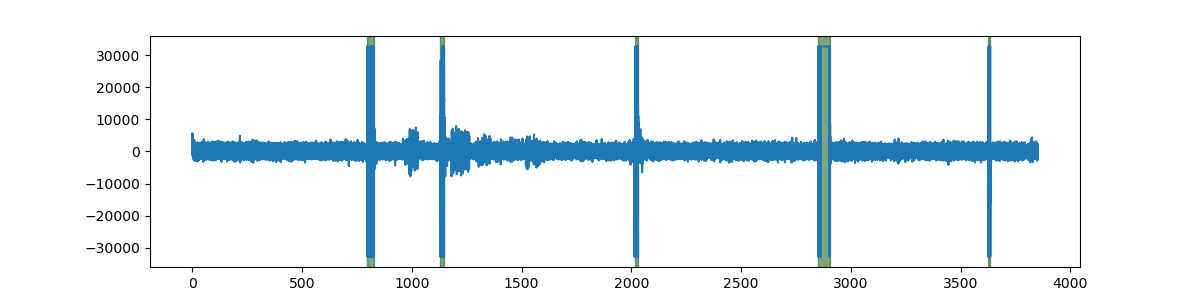

In [5]:
%matplotlib widget

chan_plot = 15
plot_signal_w_epochs(signal, chan_plot, art_epochs)

### Check Events in Neuroscope
- Load evt.art file in Neuroscope and check if it aligns with artifacts in the signal.
- Check if there are any other artifact epochs that were missed by the automatic detection

### Identify Stimulation Epochs
- Stimulation will have artifacts that are highly stereotyped

In [8]:
# Parameters
SR = sess.recinfo.dat_sampling_rate
stim_buffer = 0.01

# Get sample numbers for TTL events
ttl_events = load_all_ttl_events(sess.basepath).reset_index()
stim_events = ttl_events.loc[ttl_events["channel_states"].abs() == 1, "sample_number"]

stim_events

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")
stim_epochs = Epoch(pd.DataFrame({
    "start": stim_events.reset_index(drop=True) / SR, 
    "stop": stim_events.reset_index(drop=True) / SR + stim_buffer, 
    "label": ""
}))

stim_epochs

250 epochs
Snippet: 
         start        stop label
0  712.986500  712.996500      
1  713.976400  713.986400      
2  717.031533  717.041533      
3  718.021467  718.031467      
4  721.039900  721.049900      

In [23]:
# Parameters
SR = sess.recinfo.dat_sampling_rate
stim_buffer = 0.02

# Get sample numbers for TTL Events
ttl_events = load_all_ttl_events(sess.basepath)
stim_on_events = ttl_events.loc[ttl_events["states"] == 1, "sample_numbers"]
stim_off_events = ttl_events.loc[ttl_events["states"] == -1, "sample_numbers"]

stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")
stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / SR, 
    "stop": stim_off_events.reset_index(drop=True) / SR + stim_buffer, 
    "label": ""
}))

stim_epochs

OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate


125 epochs
Snippet: 
        start       stop label
0  11.027500  12.037400      
1  14.836167  15.846100      
2  17.854567  18.864467      
3  18.871000  19.880933      
4  21.712967  22.722867      

In [23]:
artifact_epochs = pd.concat((art_epochs.to_dataframe(), stim_epochs.to_dataframe())).reset_index()
artifact_epochs = artifact_epochs.sort_values(by="start").reset_index(drop=True)

artifact_epochs = Epoch(artifact_epochs)
artifact_epochs
artifact_epochs_file = sess.filePrefix.with_suffix(".artifact_epochs.npy")
sess.recinfo.write_epochs(epochs=artifact_epochs, ext="art")
artifact_epochs.save(artifact_epochs_file)

/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1/Creampuff_Homecage1.artifact_epochs.npy saved


### Determine and Combine All Epochs to be Classified as Artifact

In [14]:
# Determine Epochs to be added to final artifact epoch.
artifact_epochs = pd.concat((art_epochs.to_dataframe(), stim_epochs.to_dataframe())).reset_index()
artifact_epochs = artifact_epochs.sort_values(by="start").reset_index(drop=True)
merged_epochs = []

current_start = artifact_epochs.iloc[0]['start']
current_stop = artifact_epochs.iloc[0]['stop']

for i in range(1, len(combined_df)):
    row_start = combined_df.iloc[i]['start']
    row_stop = combined_df.iloc[i]['stop']

    if row_start <= current_stop:
        current_stop = max(current_stop, row_stop)
    else:
        # No overlap, save current epoch, start a new one
        merged_epochs.append({'start': current_start, 'stop': current_stop})
        current_start = row_start
        current_stop = row_stop
merged_epochs.append({'start': current_start, 'stop': current_stop})

merged_df = pd.DataFrame(merged_epochs)

combined_df.drop(combined_df.index, inplace=True)
combined_df['start'] = merged_df['start']
combined_df['stop'] = merged_df['stop']


#artifact_epochs = art_epochs

### Write to Spyking-Circus `dead_times.txt` File
- Text file containing 2 columns, start and stop of artifact epochs that should be ignored by spike sorting algorithm.

In [21]:
sess.filePrefix.with_suffix(".art_epochs.npy")
SpykingCircusIO.write_epochs(sess.basepath / 'dead_times.txt', artifact_epochs)

dead_times.txt created


In [126]:
## Create Spyking Circus Folder
basepath = Path(basepath)
circ_folder = basepath / "spyk-circ"
circ_folder.mkdir(parents=True, exist_ok=True)

sess_name = sess.filePrefix.name
files_to_copy = [sess_name+".dat", sess_name+".eeg", "dead_times.txt"]

for file_name in files_to_copy:
    source_file = basepath / file_name
    dest_file = circ_folder / file_name
    if source_file.exists():
        shutil.copy(source_file, dest_file)
    else:
        print(f"File not found: {file_name}")

Creating spyk-circ folder
